# Descriptive analysis of stroke pathway data

## Aim

Describe key pathway statistics

* Restrict data to stroke teams with at least 300 admissions (over three years) and 10 patients receiving thrombolysis.

* Analyse pathway statistics by stroke team, and combined across all stroke teams.

* Repeat team and combined analysis by age category (under aged 80 years, and aged 80+).

* Create histograms of variation in key statistics across stroke teams.

* Analyse onset-to-arrival (and breakdown by mild and non-mild stroke)

## Import libraries and data

Data has been restricted to stroke teams with at least 300 admissions, with at least 10 patients receiving thrombolysis, over three years.

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# import data
raw_data = pd.read_csv(
    './../data/2019-11-04-HQIP303-Exeter_MA.csv', low_memory=False)

In [2]:
headings = list(raw_data)
print (headings)

['StrokeTeam', 'PatientUID', 'Pathway', 'S1AgeOnArrival', 'MoreEqual80y', 'S1Gender', 'S1Ethnicity', 'S1OnsetInHospital', 'S1OnsetToArrival_min', 'S1OnsetDateType', 'S1OnsetTimeType', 'S1ArriveByAmbulance', 'S1AdmissionHour', 'S1AdmissionDay', 'S1AdmissionQuarter', 'S1AdmissionYear', 'CongestiveHeartFailure', 'Hypertension', 'AtrialFibrillation', 'Diabetes', 'StrokeTIA', 'AFAntiplatelet', 'AFAnticoagulent', 'AFAnticoagulentVitK', 'AFAnticoagulentDOAC', 'AFAnticoagulentHeparin', 'S2INR', 'S2INRHigh', 'S2INRNK', 'S2NewAFDiagnosis', 'S2RankinBeforeStroke', 'Loc', 'LocQuestions', 'LocCommands', 'BestGaze', 'Visual', 'FacialPalsy', 'MotorArmLeft', 'MotorArmRight', 'MotorLegLeft', 'MotorLegRight', 'LimbAtaxia', 'Sensory', 'BestLanguage', 'Dysarthria', 'ExtinctionInattention', 'S2NihssArrival', 'S2BrainImagingTime_min', 'S2StrokeType', 'S2Thrombolysis', 'Haemorrhagic', 'TimeWindow', 'Comorbidity', 'Medication', 'Refusal', 'Age', 'Improving', 'TooMildSevere', 'TimeUnknownWakeUp', 'OtherMedical

Show data types

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246676 entries, 0 to 246675
Data columns (total 62 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   StrokeTeam              246676 non-null  object 
 1   PatientUID              246676 non-null  object 
 2   Pathway                 246676 non-null  int64  
 3   S1AgeOnArrival          246676 non-null  object 
 4   MoreEqual80y            246676 non-null  object 
 5   S1Gender                246676 non-null  object 
 6   S1Ethnicity             246676 non-null  object 
 7   S1OnsetInHospital       246676 non-null  object 
 8   S1OnsetToArrival_min    154640 non-null  float64
 9   S1OnsetDateType         246676 non-null  object 
 10  S1OnsetTimeType         246676 non-null  object 
 11  S1ArriveByAmbulance     232503 non-null  object 
 12  S1AdmissionHour         246676 non-null  object 
 13  S1AdmissionDay          246676 non-null  object 
 14  S1AdmissionQuarter  

## Average yearly admissions

In [4]:
int(raw_data.shape[0]/3)

82225

## Restrict original data to hospitals with at least 300 admissions + 10 thrombolysis patients

In [5]:
keep = []

groups = raw_data.groupby('StrokeTeam') # creates a new object of groups of data

for index, group_df in groups: # each group has an index and a dataframe of data
    
    # Skip if total admissions less than 300 or total thrombolysis < 10
    admissions = group_df.shape[0]
    thrombolysis_received = group_df['S2Thrombolysis'] == 'Yes' 
    if (admissions < 300) or (thrombolysis_received.sum() < 10):
        continue
    
    else: 
        keep.append(group_df)

# Concatenate output
data = pd.DataFrame()
data = pd.concat(keep)

print (data.shape)

(239505, 62)


## Stroke types

In [6]:
data['S2StrokeType'].value_counts()/data['S2StrokeType'].shape[0]


Infarction                           0.873435
Primary Intracerebral Haemorrhage    0.122106
Name: S2StrokeType, dtype: float64

## Compare thrombolysis use for out-of-hospital and in-hospital stroke onset

In [7]:
# Create boolean feature for use of thrombolysis
data['use_thrombolysis'] = data['S2Thrombolysis'] == 'Yes'

# Show percentage of strokes have in hospital onset
in_hospital_onset = data['S1OnsetInHospital'] == 'Yes'
percent_in_hosp = in_hospital_onset.mean() * 100
print (
    f'Percentage of stroke with in-hospital onset: {percent_in_hosp:0.1f}')

# In hospital onset
mask = data['S1OnsetInHospital'] == 'Yes'
thrombolysis_in = data[mask]['use_thrombolysis'].mean() * 100
print (
    f'Thrombolysis use (%) for in-hospital-onset {thrombolysis_in:0.1f}')

# Out of hospital onset
mask = data['S1OnsetInHospital'] == 'No'
thrombolysis_out = data[mask]['use_thrombolysis'].mean() * 100
print (
    f'Thrombolysis use (%) for out-of-hospital-onset {thrombolysis_out:0.1f}')

Percentage of stroke with in-hospital onset: 5.3
Thrombolysis use (%) for in-hospital-onset 12.3
Thrombolysis use (%) for out-of-hospital-onset 11.8


## Restrict data to out-of-hospital onset

In [8]:
mask = data['S1OnsetInHospital'] == 'No'
data = data[mask]

## Function for analysis by stroke team

In [9]:
def analyse_by_team(input_data):
    
    # Copy data
    data = input_data.copy()
    
    # Set up results lists
    stroke_team = []
    admissions = []
    age_80_plus = []
    
    onset_known = []
    rankin_before_stroke_all = []
    nihss_arrival_all = []
    known_arrival_within_4hrs = []
    rankin_before_stroke_4hrs = []
    nihss_arrival_4hrs = []
    onset_arrival_mins_mu = []
    onset_arrival_mins_sigma = []
    scan_within_4_hrs = []
    arrival_scan_mins_mu = []
    arrival_scan_mins_sigma = []
    scan_needle_mins_mu = []
    scan_needle_mins_sigma = []
    arrival_needle_mins_mu = []
    arrival_needle_mins_sigma = []
    onset_needle_mins_mu = []
    onset_needle_mins_sigma = []
    thrombolysis_rate = []
    thrombolysis_after_180_min = []
    thrombolysis_after_270_min = []
    eligible = []
    
    # Split data by stroke team
    groups = data.groupby('StrokeTeam') # creates a new object of groups of data
    group_count = 0
    for index, group_df in groups: 
        group_count += 1
        
        # Record stroke team
        stroke_team.append(index)

        # Record admission numbers
        admissions.append(group_df.shape[0])

        # Get thrombolysis rate
        thrombolysed = group_df['S2Thrombolysis'] == 'Yes'
        thrombolysis_rate.append(thrombolysed.mean())
        
        # Get Rankin before stroke and NIHSS on arrival
        rankin_before_stroke_all.append(group_df['S2RankinBeforeStroke'].mean())
        nihss_arrival_all.append(group_df['S2NihssArrival'].mean())
        
        # Record onset known proportion and remove rest
        f = lambda x: x in ['Precise', 'Best estimate']
        mask = group_df['S1OnsetTimeType'].apply(f)
        onset_known.append(mask.mean())
        group_df = group_df[mask]

        # Record onset <4 hours and remove rest
        mask = group_df['S1OnsetToArrival_min'] <= 240
        known_arrival_within_4hrs.append(mask.mean())
        group_df = group_df[mask]
        
        # Get Rankin before stroke and NIHSS on arrival
        rankin_before_stroke_4hrs.append(
            group_df['S2RankinBeforeStroke'].mean())
        nihss_arrival_4hrs.append(group_df['S2NihssArrival'].mean())

        # Calc proportion 80+ (of those arriving within 4 hours)
        age_filter = group_df['MoreEqual80y'] == 'Yes'
        age_80_plus.append(age_filter.mean())

        # Get onset to arrival (of those arriving within 4 hours)
        onset_to_arrival = group_df['S1OnsetToArrival_min']
        onset_arrival_mins_mu.append(onset_to_arrival.mean())
        onset_arrival_mins_sigma.append(onset_to_arrival.std())

        # Record scan within 4 hours of arrival (and remove the rest)
        mask = group_df['S2BrainImagingTime_min'] <= 240
        scan_within_4_hrs.append(mask.mean())
        group_df = group_df[mask]

        # Record arrival to scan (of those arriving within 4 hours)
        arrival_to_scan = group_df['S2BrainImagingTime_min']
        arrival_scan_mins_mu.append(arrival_to_scan.mean())
        arrival_scan_mins_sigma.append(arrival_to_scan.std())

        # Thrombolysis given (of those scanned within 4 hours of arrival)
        thrombolysed_mask = group_df['S2Thrombolysis'] == 'Yes'
        eligible.append(thrombolysed_mask.mean())

        # Scan to needle
        thrombolysed = group_df[thrombolysed_mask]
        scan_to_needle = (thrombolysed['S2ThrombolysisTime_min'] - 
                          thrombolysed['S2BrainImagingTime_min'])
        scan_needle_mins_mu.append(scan_to_needle.mean())
        scan_needle_mins_sigma.append(scan_to_needle.std())
        
        # Arrival to needle
        arrival_needle_mins_mu.append(
            thrombolysed['S2ThrombolysisTime_min'].mean())
        arrival_needle_mins_sigma.append(
            thrombolysed['S2ThrombolysisTime_min'].std())
        
        # Onset to needle
        onset_to_needle = (thrombolysed['S1OnsetToArrival_min'] + 
                          thrombolysed['S2ThrombolysisTime_min'])
        onset_needle_mins_mu.append(onset_to_needle.mean())
        onset_needle_mins_sigma.append(onset_to_needle.std())
        
        # Proportions of thrombolysis after 180 or 270 min
        thrombolysis_after_180 = onset_to_needle > 180
        thrombolysis_after_270 = onset_to_needle > 270
        thrombolysis_after_180_min.append(thrombolysis_after_180.mean())
        thrombolysis_after_270_min.append(thrombolysis_after_270.mean())
        
    df = pd.DataFrame()
    df['stroke_team'] = stroke_team
    df['thrombolysis_rate'] = thrombolysis_rate
    df['arrivals'] = admissions
    df['80_plus'] = age_80_plus
    df['rankin_before_stroke_all'] = rankin_before_stroke_all
    df['nihss_arrival_all'] = nihss_arrival_all
    df['onset_known'] = onset_known
    df['known_arrival_within_4hrs'] = known_arrival_within_4hrs
    df['known_arrival_within_4hrs_all'] = \
        df['onset_known'] * df['known_arrival_within_4hrs']
    df['rankin_before_stroke_4hrs'] = rankin_before_stroke_4hrs
    df['nihss_arrival_4hrs'] = nihss_arrival_4hrs
    df['onset_arrival_mins_mu'] = onset_arrival_mins_mu
    df['onset_arrival_mins_sigma'] = onset_arrival_mins_sigma
    df['scan_within_4_hrs'] = scan_within_4_hrs
    df['arrival_scan_mins_mu'] = arrival_scan_mins_mu
    df['arrival_scan_mins_sigma'] = arrival_scan_mins_sigma
    df['eligable'] = eligible
    df['scan_needle_mins_mu'] = scan_needle_mins_mu
    df['scan_needle_mins_sigma'] = scan_needle_mins_sigma
    df['arrival_needle_mins_mu'] = arrival_needle_mins_mu
    df['arrival_needle_mins_sigma'] = arrival_needle_mins_sigma
    df['onset_needle_mins_mu'] = onset_needle_mins_mu
    df['onset_needle_mins_sigma'] = onset_needle_mins_sigma   
    df['thrombolysis_after_180_min'] = thrombolysis_after_180_min
    df['thrombolysis_after_270_min'] = thrombolysis_after_270_min
    
    return df

## Create analysis by team and show summary

In [10]:
analysis_by_team = analyse_by_team(data)
analysis_by_team.to_csv('output/full_analysis_by_team.csv')
summary_by_hospital = analysis_by_team.describe().T
summary_by_hospital

,count,mean,std,min,25%,50%,75%,max
thrombolysis_rate,132.0,0.114536,0.035449,0.015306,0.093239,0.109547,0.133314,0.243174
arrivals,132.0,1718.333333,832.249409,303.000000,1133.000000,1632.500000,2265.250000,6118.000000
80_plus,132.0,0.425635,0.056416,0.292308,0.387089,0.427573,0.457896,0.576220
rankin_before_stroke_all,132.0,1.040435,0.258761,0.512531,0.843626,1.032913,1.202876,1.860384
nihss_arrival_all,132.0,7.393900,0.948271,4.543634,6.698829,7.404792,8.067855,10.277926
onset_known,132.0,0.665679,0.134064,0.344784,0.573593,0.641978,0.752881,0.988275
known_arrival_within_4hrs,132.0,0.600743,0.089733,0.257034,0.557876,0.608542,0.662325,0.813584
known_arrival_within_4hrs_all,132.0,0.392147,0.062162,0.222646,0.352730,0.392458,0.430548,0.558317
rankin_before_stroke_4hrs,132.0,1.052002,0.264767,0.455108,0.877631,1.059910,1.204151,1.843863
nihss_arrival_4hrs,132.0,9.119220,1.107748,6.108696,8.419594,9.168358,9.916195,11.728546


In [11]:
# Save summary to csv
summary_by_hospital.to_csv('output/pathway_summary_by_hopsital.csv')

## Analyse for all patients together

In [12]:
# Set all StrokeTeam to same
single_group = data.copy()
single_group['StrokeTeam'] = "na"
analysis_all = analyse_by_team(single_group).T

# Add means to new DataFrame
stats_by_age = pd.DataFrame()
stats_by_age['all'] = analysis_all[0]

In [13]:
analysis_all.to_csv('output/pathway_summary_all.csv')

## Analysis by under age 80 vs 80+

Repeat general and hospital level analysis by age stratification

In [14]:
# Mask for under 80
mask = data['MoreEqual80y'] == 'No'
data_under_80 = data[mask]
# Mask for 80 plus
mask = data['MoreEqual80y'] == 'Yes'
data_80_plus = data[mask]

### Under age 80

In [15]:
analysis_by_team_under_80 = analyse_by_team(data_under_80)
summary_by_hospital_under_80 = analysis_by_team_under_80.describe().T
summary_by_hospital_under_80

,count,mean,std,min,25%,50%,75%,max
thrombolysis_rate,132.0,0.127182,0.038002,0.013064,0.104283,0.123472,0.150482,0.262436
arrivals,132.0,1003.037879,529.410379,173.000000,636.000000,941.500000,1286.500000,3999.000000
80_plus,132.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
rankin_before_stroke_all,132.0,0.642800,0.204014,0.221030,0.493693,0.609459,0.758040,1.420674
nihss_arrival_all,132.0,6.286699,0.856764,3.749164,5.766698,6.342502,6.799700,9.328110
onset_known,132.0,0.679982,0.130020,0.377171,0.588716,0.660804,0.760079,0.985591
known_arrival_within_4hrs,132.0,0.584347,0.090390,0.222084,0.537210,0.594057,0.649928,0.807645
known_arrival_within_4hrs_all,132.0,0.389793,0.060399,0.212589,0.351842,0.391457,0.423625,0.544338
rankin_before_stroke_4hrs,132.0,0.617723,0.214004,0.148148,0.462979,0.597158,0.752650,1.443884
nihss_arrival_4hrs,132.0,8.085814,1.080190,5.147959,7.459996,8.037950,8.714991,11.512821


In [16]:
summary_by_hospital_under_80.to_csv('output/pathway_summary_by_hopsital_under_80.csv')

In [17]:
 # Set all StrokeTeam to same
single_group = data_under_80.copy()
single_group['StrokeTeam'] = "na"
analysis_all = analyse_by_team(single_group).T
stats_by_age['under_80'] = analysis_all[0]

### Aged 80+

In [18]:
analysis_by_team_80_plus = analyse_by_team(data_80_plus)
summary_by_hospital_80_plus = analysis_by_team_80_plus.describe().T
summary_by_hospital_80_plus

,count,mean,std,min,25%,50%,75%,max
thrombolysis_rate,132.0,0.097072,0.037177,0.015184,0.071957,0.090386,0.118358,0.227273
arrivals,132.0,715.295455,324.288269,130.000000,519.000000,693.500000,887.250000,2119.000000
80_plus,132.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
rankin_before_stroke_all,132.0,1.582028,0.329839,0.799699,1.355713,1.583800,1.794138,2.464387
nihss_arrival_all,132.0,8.949314,1.154855,5.969027,8.166105,8.990764,9.807674,12.285714
onset_known,132.0,0.646519,0.141493,0.310705,0.543596,0.622715,0.740186,0.992000
known_arrival_within_4hrs,132.0,0.624133,0.093277,0.312377,0.577418,0.627499,0.683352,0.821990
known_arrival_within_4hrs_all,132.0,0.395484,0.069188,0.194872,0.355810,0.392473,0.442737,0.601429
rankin_before_stroke_4hrs,132.0,1.638257,0.335931,0.863830,1.395506,1.650321,1.864107,2.386986
nihss_arrival_4hrs,132.0,10.546849,1.371413,6.688889,9.689962,10.640593,11.557606,13.642157


In [19]:
summary_by_hospital_80_plus.to_csv('output/pathway_summary_by_hopsital_80_plus.csv')

In [20]:
 # Set all StrokeTeam to same
single_group = data_80_plus.copy()
single_group['StrokeTeam'] = "na"
analysis_all = analyse_by_team(single_group).T
stats_by_age['80+'] = analysis_all[0]

Show comparison of means by age group

In [21]:
stats_by_age.to_csv('output/summary_by_age_group.csv')
stats_by_age

,all,under_80,80+
stroke_team,na,na,na
thrombolysis_rate,0.118239,0.130445,0.101124
arrivals,226820,132401,94419
80_plus,0.423219,0.0,1.0
rankin_before_stroke_all,1.047315,0.654225,1.598534
nihss_arrival_all,7.46584,6.363859,9.059266
onset_known,0.668596,0.681943,0.64988
known_arrival_within_4hrs,0.586399,0.568081,0.613354
known_arrival_within_4hrs_all,0.392064,0.387399,0.398606
rankin_before_stroke_4hrs,1.059689,0.623704,1.653869


## Summary figure

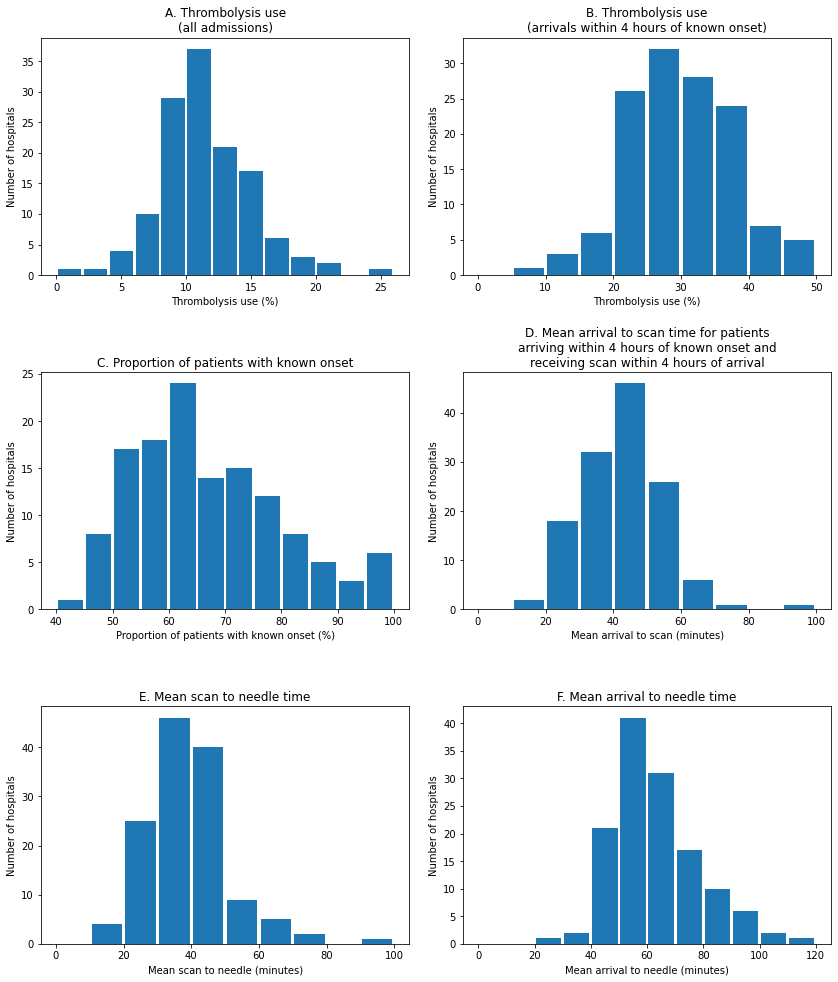

In [22]:
# Set up figure
fig = plt.figure(figsize=(12,14))

# Subplot 1: Histogram of thrombolysis rate
ax1 = fig.add_subplot(321)
x = analysis_by_team['thrombolysis_rate'] * 100
bins = np.arange(0, x.max()+2, 2)
ax1.hist(x, bins=bins, rwidth=0.9)
ax1.set_xlabel('Thrombolysis use (%)')
ax1.set_ylabel('Number of hospitals')
ax1.set_title('A. Thrombolysis use\n(all admissions)')

# Subplot 2: Histogram of thrombolysis rate for patients arriving in 4 hours
ax2 = fig.add_subplot(322)
x = analysis_by_team['eligable'] * 100
bins = np.arange(0, x.max()+5, 5)
ax2.hist(x, bins=bins, rwidth=0.9)
ax2.set_xlabel('Thrombolysis use (%)')
ax2.set_ylabel('Number of hospitals')
ax2.set_title('B. Thrombolysis use\n(arrivals within 4 hours of known onset)')

# Subplot 3: Histogram of proportion of patients with known onset
ax3 = fig.add_subplot(323)
x = analysis_by_team['onset_known'] * 100
bins = np.arange(40, x.max()+5, 5)
ax3.hist(x, bins=bins, rwidth=0.9)
ax3.set_xlabel('Proportion of patients with known onset (%)')
ax3.set_ylabel('Number of hospitals')
ax3.set_title('C. Proportion of patients with known onset')

# Subplot 4: Histogram of mean Arrival to scan times
ax4 = fig.add_subplot(324)
x = analysis_by_team['arrival_scan_mins_mu']
bins = np.arange(0, x.max()+10, 10)
ax4.hist(x, bins=bins, rwidth=0.9)
ax4.set_xlabel('Mean arrival to scan (minutes)')
ax4.set_ylabel('Number of hospitals')
ax4.set_title('''D. Mean arrival to scan time for patients
arriving within 4 hours of known onset and
receiving scan within 4 hours of arrival''')

# Subplot 5: Histogram of mean scan to needle times
ax5 = fig.add_subplot(325)
x = analysis_by_team['scan_needle_mins_mu']
bins = np.arange(0, x.max()+10, 10)
ax5.hist(x, bins=bins, rwidth=0.9)
ax5.set_xlabel('Mean scan to needle (minutes)')
ax5.set_ylabel('Number of hospitals')
ax5.set_title('E. Mean scan to needle time')

# Subplot 6: Histogram of mean arrival to needle times
ax6 = fig.add_subplot(326)
x = analysis_by_team['arrival_needle_mins_mu']
bins = np.arange(0, x.max()+10, 10)
ax6.hist(x, bins=bins, rwidth=0.9)
ax6.set_xlabel('Mean arrival to needle (minutes)')
ax6.set_ylabel('Number of hospitals')
ax6.set_title('F. Mean arrival to needle time')

# Save and show
plt.tight_layout(pad=2)
plt.savefig('output/pathway_summary_six_histograms.jpg', dpi=300)
plt.show();

## Analysis of stroke severity

In [23]:
# Restrict to known NIHSS
mask = data['S2NihssArrival'] >= 0
known_NIHSS = data[mask]
counts = pd.DataFrame(known_NIHSS['S2NihssArrival'].value_counts().sort_index())
counts['cum_sum'] = np.cumsum(counts['S2NihssArrival'])
counts

,S2NihssArrival,cum_sum
0.0,14658,14658
1.0,21117,35775
2.0,27521,63296
3.0,22765,86061
4.0,18955,105016
5.0,14686,119702
6.0,11783,131485
7.0,9334,140819
8.0,7519,148338
9.0,5987,154325


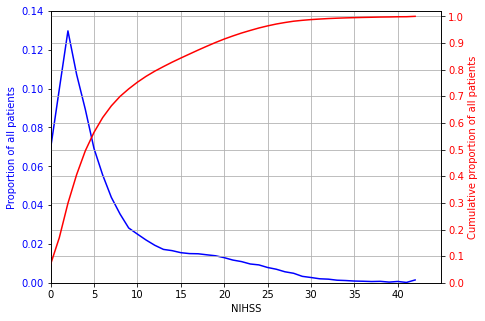

In [24]:
# Set up figure
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(111)

total = counts['S2NihssArrival'].sum()
x = list(counts.index)
y1 = counts['S2NihssArrival'] / total
y2 = counts['cum_sum'] / total
ax1.plot(x,y1,color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_ylim(0, 0.14)
ax1.set_ylabel('Proportion of all patients', color='b')
ax1.set_xlabel('NIHSS')
ax1.set_xlim(0,45)
ax1.set_xticks(np.arange(0,42,5))
ax1.grid(axis='x')

# Add cumsum to second axis
ax2 = ax1.twinx() 
ax2.plot(x,y2,label='Cumulative sum', color='r')
ax2.set_ylim(0,1.02)
ax2.set_yticks(np.arange(0,1.01,0.1))
ax2.set_xticks(np.arange(0,42,5))
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylabel('Cumulative proportion of all patients', color='r')
ax2.grid('both')

plt.savefig('output/nihss_count.jpg', dpi=300)
plt.show()

## Analyse onset-to-arrival times

All arrivals

In [25]:
# Count patients with determined NIHSS
total_with_determined_nihss = np.sum(data['S2NihssArrival'] >= 0)
proportion_with_determined_nihss = np.mean(data['S2NihssArrival'] >= 0)

# Restrict to known onset
f = lambda x: x in ['Precise', 'Best estimate']
mask = data['S1OnsetTimeType'].apply(f)
data_known_onset = data[mask]
prop_known_onset_all = mask.mean()

# Get counts of arrival times, up to 12 hours, in 30 min bins
bins = np.arange(0, 721, 30)
arrivals_all, _ = np.histogram(data_known_onset['S1OnsetToArrival_min'], bins)
prop_arrivals_in_12_hours = np.sum(arrivals_all) / mask.sum()
df_all_arrivals = pd.DataFrame()
df_all_arrivals['Arrival bin (upper)'] = bins[1:]
df_all_arrivals.set_index('Arrival bin (upper)', inplace=True)
df_all_arrivals['Counts'] = arrivals_all
df_all_arrivals['Prop known onset'] = arrivals_all / mask.sum()
df_all_arrivals['Cumulatative prop'] = np.cumsum(df_all_arrivals['Prop known onset'])

print('All arrivals:')
print('-------------')
print(f'Proporotion of arrivals with determmined NIHSS: {proportion_with_determined_nihss:0.3}')
print(f'Proportion of arrivals with known stroke onset: {prop_known_onset_all:0.3f}')
print(f'Proportion known stroke onset arriving within 12 hours: {prop_arrivals_in_12_hours:0.3f}')
print (df_all_arrivals)

All arrivals:
-------------
Proporotion of arrivals with determmined NIHSS: 0.935
Proportion of arrivals with known stroke onset: 0.669
Proportion known stroke onset arriving within 12 hours: 0.799
                     Counts  Prop known onset  Cumulatative prop
Arrival bin (upper)                                             
30                     1819          0.011995           0.011995
60                    11283          0.074401           0.086396
90                    23536          0.155198           0.241594
120                   18806          0.124008           0.365603
150                   12402          0.081780           0.447382
180                    8791          0.057969           0.505351
210                    6731          0.044385           0.549736
240                    5283          0.034837           0.584572
270                    4344          0.028645           0.613217
300                    3653          0.024088           0.637305
330                   

Mild stroke (NIHSS <= 5)

In [26]:
# Proportion mild stroke
mild = data['S2NihssArrival'] <=5
prop_mild = mild.sum()/data.shape[0]
print (f'Proportion mild {prop_mild:0.2f}')

Proportion mild 0.53


In [27]:
# Restrict to NIHSS <5
mask = data['S2NihssArrival'] <=5
data_mild = data[mask]
proportion_mild_stroke = mask.sum() / total_with_determined_nihss

# Restrict to known onset
f = lambda x: x in ['Precise', 'Best estimate']
mask = data_mild['S1OnsetTimeType'].apply(f)
data_known_onset = data_mild[mask]
prop_known_onset_mild = mask.mean()

# Get counts of arrival times, up to 12 hours, in 30 min bins
bins = np.arange(0, 721, 30)
arrivals_all, _ = np.histogram(data_known_onset['S1OnsetToArrival_min'], bins)
prop_arrivals_in_12_hours = np.sum(arrivals_all) / mask.sum()
df_mild_arrivals = pd.DataFrame()
df_mild_arrivals['Arrival bin (upper)'] = bins[1:]
df_mild_arrivals.set_index('Arrival bin (upper)', inplace=True)
df_mild_arrivals['Counts'] = arrivals_all
df_mild_arrivals['Prop known onset'] = arrivals_all / mask.sum()
df_mild_arrivals['Cumulatative prop'] = np.cumsum(df_mild_arrivals['Prop known onset'])

print('Mild stroke (NIHSS <= 5):')
print('-------------------------')
print(f'Proportion of all arrivals, with determined NIHSS, with mild stroke: {proportion_mild_stroke:0.3f}')
print(f'Proportion of arrivals with known stroke onset: {prop_known_onset_mild:0.3f}')
print(f'Proportion known stroke onset arriving within 12 hours: {prop_arrivals_in_12_hours:0.3f}')
print (df_mild_arrivals)


Mild stroke (NIHSS <= 5):
-------------------------
Proportion of all arrivals, with determined NIHSS, with mild stroke: 0.564
Proportion of arrivals with known stroke onset: 0.645
Proportion known stroke onset arriving within 12 hours: 0.723
                     Counts  Prop known onset  Cumulatative prop
Arrival bin (upper)                                             
30                      810          0.010485           0.010485
60                     3767          0.048760           0.059245
90                     8347          0.108043           0.167288
120                    7769          0.100562           0.267850
150                    5840          0.075593           0.343443
180                    4290          0.055530           0.398972
210                    3464          0.044838           0.443810
240                    2807          0.036334           0.480144
270                    2369          0.030664           0.510808
300                    2010          0.026

Non-mild stroke (NIHSS > 5)

In [28]:
# Proportion non-mild stroke
non_mild = data['S2NihssArrival'] >5
prop_non_mild = non_mild.sum()/data.shape[0]
print (f'Proportion non-mild {prop_non_mild:0.2f}')

Proportion non-mild 0.41


In [29]:
# Restrict to NIHSS >5
mask = data['S2NihssArrival'] >5
data_not_mild = data[mask]
proportion_not_mild_stroke = mask.sum() / total_with_determined_nihss

# Restrict to known onset
f = lambda x: x in ['Precise', 'Best estimate']
mask = data_not_mild['S1OnsetTimeType'].apply(f)
data_known_onset = data_not_mild[mask]
prop_known_onset_not_mild = mask.mean()

# Get counts of arrival times, up to 12 hours, in 30 min bins
bins = np.arange(0, 721, 30)
arrivals_all, _ = np.histogram(data_known_onset['S1OnsetToArrival_min'], bins)
prop_arrivals_in_12_hours = np.sum(arrivals_all) / mask.sum()
df_not_mild_arrivals = pd.DataFrame()
df_not_mild_arrivals['Arrival bin (upper)'] = bins[1:]
df_not_mild_arrivals.set_index('Arrival bin (upper)', inplace=True)
df_not_mild_arrivals['Counts'] = arrivals_all
df_not_mild_arrivals['Prop known onset'] = arrivals_all / mask.sum()
df_not_mild_arrivals['Cumulatative prop'] = np.cumsum(
    df_not_mild_arrivals['Prop known onset'])

print('Non-mild stroke (NIHSS >5):')
print('-------------------------')
print(f'Proportion of arrivals with known stroke onset: {prop_known_onset_not_mild:0.3f}')
print(f'Proportion of all arrivals, with determined NIHSS, with NIHSS >5: {proportion_not_mild_stroke:0.3f}')
print(f'Proportion known stroke onset arriving within 12 hours: {prop_arrivals_in_12_hours:0.3f}')
print (df_not_mild_arrivals)

Non-mild stroke (NIHSS >5):
-------------------------
Proportion of arrivals with known stroke onset: 0.715
Proportion of all arrivals, with determined NIHSS, with NIHSS >5: 0.436
Proportion known stroke onset arriving within 12 hours: 0.883
                     Counts  Prop known onset  Cumulatative prop
Arrival bin (upper)                                             
30                      915          0.013852           0.013852
60                     6813          0.103141           0.116993
90                    13655          0.206722           0.323715
120                    9899          0.149860           0.473575
150                    5874          0.088926           0.562501
180                    4058          0.061434           0.623935
210                    2920          0.044206           0.668140
240                    2238          0.033881           0.702021
270                    1756          0.026584           0.728605
300                    1421          0.0215

NIHSS >10

In [30]:
# Restrict to NIHSS >10
mask = data['S2NihssArrival'] >10
data_nihss_11plus = data[mask]
proportion__11plus = mask.sum() / total_with_determined_nihss

# Restrict to known onset
f = lambda x: x in ['Precise', 'Best estimate']
mask = data_nihss_11plus['S1OnsetTimeType'].apply(f)
data_known_onset = data_nihss_11plus[mask]
prop_known_onset_11plus = mask.mean()

# Get counts of arrival times, up to 12 hours, in 30 min bins
bins = np.arange(0, 721, 30)
arrivals_all, _ = np.histogram(data_known_onset['S1OnsetToArrival_min'], bins)
prop_arrivals_in_12_hours = np.sum(arrivals_all) / mask.sum()
df_arrivals_11plus = pd.DataFrame()
df_arrivals_11plus['Arrival bin (upper)'] = bins[1:]
df_arrivals_11plus.set_index('Arrival bin (upper)', inplace=True)
df_arrivals_11plus['Counts'] = arrivals_all
df_arrivals_11plus['Prop known onset'] = arrivals_all / mask.sum()
df_arrivals_11plus['Cumulatative prop'] = np.cumsum(
    df_arrivals_11plus['Prop known onset'])

print('Non-mild stroke (NIHSS >10):')
print('-------------------------')
print(f'Proportion of arrivals with known stroke onset: {prop_known_onset_11plus:0.3f}')
print(f'Proportion of all arrivals, with determined NIHSS, with NIHH >10: {proportion__11plus:0.3f}')
print(f'Proportion known stroke onset arriving within 12 hours: {prop_arrivals_in_12_hours:0.3f}')
print (df_arrivals_11plus)

Non-mild stroke (NIHSS >10):
-------------------------
Proportion of arrivals with known stroke onset: 0.726
Proportion of all arrivals, with determined NIHSS, with NIHH >10: 0.247
Proportion known stroke onset arriving within 12 hours: 0.910
                     Counts  Prop known onset  Cumulatative prop
Arrival bin (upper)                                             
30                      543          0.014264           0.014264
60                     4644          0.121992           0.136256
90                     8890          0.233529           0.369786
120                    6076          0.159609           0.529395
150                    3409          0.089550           0.618945
180                    2281          0.059919           0.678864
210                    1586          0.041662           0.720526
240                    1222          0.032100           0.752627
270                     951          0.024982           0.777608
300                     739          0.019

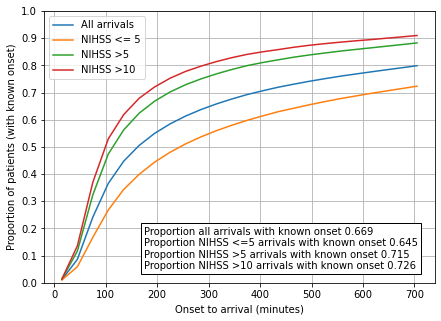

In [31]:
# Set up figure
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
x = df_all_arrivals.index
x -= 15 # plot at centre of bin
y1 = df_all_arrivals['Cumulatative prop']
y2 = df_mild_arrivals['Cumulatative prop']
y3 = df_not_mild_arrivals['Cumulatative prop']
y4 = df_arrivals_11plus['Cumulatative prop']

ax.plot(x, y1, label = 'All arrivals')
ax.plot(x, y2, label = 'NIHSS <= 5')
ax.plot(x, y3, label = 'NIHSS >5')
ax.plot(x, y4, label = 'NIHSS >10')

ax.set_xlabel('Onset to arrival (minutes)')
ax.set_ylabel('Proportion of patients (with known onset)')
ax.set_ylim(0, 720)
ax.set_ylim(0, 1.0)
ax.set_yticks(np.arange(0, 1.01, 0.1))

ax.grid()

text = f'''Proportion all arrivals with known onset {prop_known_onset_all:0.3}
Proportion NIHSS <=5 arrivals with known onset {prop_known_onset_mild:0.3}
Proportion NIHSS >5 arrivals with known onset {prop_known_onset_not_mild:0.3}
Proportion NIHSS >10 arrivals with known onset {prop_known_onset_11plus:0.3}'''
props = dict(boxstyle='square', facecolor='white', alpha=1.0)
plt.text(175, 0.05, text, bbox=props)

ax.legend(loc='upper left')

plt.savefig('output/onset_to_arrival.jpg', dpi=300)

plt.show()

## Queries on time of arrival and NIHSS for patients who receive thrombolysis

See also later section on comparison of average values for patients who receive thrombolysis and those that do not (though that data is for patients who arrive within 4 hours of known stroke onset)

In [32]:
data_thrombolysed = data[data['S2Thrombolysis'] == 'Yes']
thrombolysed = dict()

# Onset known
onset_known = (data_thrombolysed['S1OnsetTimeType'] == 'Precise') | (data_thrombolysed['S1OnsetTimeType'] == 'Best estimate')
thrombolysed['onset known'] = onset_known.mean()

# Arrival within 4 hours
arrive_4_hours = data_thrombolysed['S1OnsetToArrival_min'] <= 240
thrombolysed['arrive within 4 hours'] = arrive_4_hours.mean()

# Arrival within 6 hours
arrive_6_hours = data_thrombolysed['S1OnsetToArrival_min'] <= 360
thrombolysed['arrive within 6 hours'] = arrive_6_hours.mean()

# NIHSS >5
nihss_greater_5 = data_thrombolysed['S2NihssArrival'] >5
thrombolysed['nihss 6+'] = nihss_greater_5.mean()
nihss_greater_5_arrival_4_hrs = nihss_greater_5 & arrive_4_hours
thrombolysed['nihss 6+ and arrive in 4 hours'] = nihss_greater_5_arrival_4_hrs.mean()
nihss_greater_5_arrival_6_hrs = nihss_greater_5 & arrive_6_hours
thrombolysed['nihss 6+ and arrive in 6 hours'] = nihss_greater_5_arrival_6_hrs.mean()

# NIHSS >10
nihss_greater_10 = data_thrombolysed['S2NihssArrival'] >10
thrombolysed['nihss 11+'] = nihss_greater_10.mean()
nihss_greater_10_arrival_4_hrs = nihss_greater_10 & arrive_4_hours
thrombolysed['nihss 11+ and arrive in 4 hours'] = nihss_greater_10_arrival_4_hrs.mean()
nihss_greater_10_arrival_6_hrs = nihss_greater_10 & arrive_6_hours
thrombolysed['nihss 11+ and arrive in 6 hours'] = nihss_greater_10_arrival_6_hrs.mean()

thrombolysed = pd.Series(thrombolysed)
thrombolysed

onset known                        0.988926
arrive within 4 hours              0.979045
arrive within 6 hours              0.987211
nihss 6+                           0.739252
nihss 6+ and arrive in 4 hours     0.723330
nihss 6+ and arrive in 6 hours     0.729520
nihss 11+                          0.451247
nihss 11+ and arrive in 4 hours    0.440807
nihss 11+ and arrive in 6 hours    0.444573
dtype: float64

## General observations

* There are 239,505 admissions (2016-2018) to 132 stroke teams that receive at least 300 admissions and provide thrombolysis to at least 10 patients over the course of three years (2016-2018).

* 5.3% of patients have an in-hospital stroke onset; 12.3% receive thrombolysis. 94.7% of patients have an out-of-hospital stroke onset; 11.8% receive thrombolysis.

The following statistic apply to out-of-hospital onset stroke patients only

* 43% of arrivals are aged 80 or more.

* 67% of all patients have a determined stroke time of onset, 60% of whom arrive within 4 hours of known stroke onset. 40% of all arrivals arrive within 4 hours of known stroke onset.

* The average NIHSS (stroke severity) is 7.4

Of those arriving within 4 hours of known stroke onset:

* The average onset-to-arrival time is 111 minutes.

* 95% receive a scan within 4 hours of arrival, with an average arrival-to-scan time of 43 minutes.

* 30% of those who receive a scan within 4 hours of known stroke onset, and 11.8% of all arrivals, receive thrombolysis. The average scan-to-needle time is 40 minutes, the average arrival-to-needle time is 63 minutes, and the average onset-to-needle time is 158 minutes. 

On inter-hospital variation:

* Thrombolysis use varies from 1.5% to 24.3% of all patients, and 7.3% to 49.7% of patients arriving within 4 hours of known stroke onset.

* The proportion of determined stroke onsets ranges from 34% to 99%.

* The proportion of patients arriving within 4 hours of known stroke onset ranges from 22% to 56%.

* The proportion of patients scanned within 4 hours of arrival ranges from 85% to 100%.

* Average arrival-to-scan (for those arriving within 4 hours of known stroke onset and scanned within 4 hours of arrival) ranges from 19 to 93 minutes.

* Average arrival-to-needle time varies from 26 to 111 minutes.

* The proportion of patients aged 80+ varies from 29% to 58%.

* The average NIHSS (stroke severity) ranges from 6.1 to 11.7.

On differences by age group (under age 80 years vs 80+):

* 10.1% of arrivals aged 80+ receive thrombolysis, c.f. 13.0% of those under age 80.

* 39% of arrivals aged 80+ arrive within 4 hours of known stroke onset, c.f. 40% of those under age 80.

* The average disability (Rankin) before stroke is 1.7 for those aged 80+, c.f. 0.6 for those under age 80.

* The average stroke severity (NIHSS) on arrival is 10.7 for those aged 80+, c.f. 8.2 for those under age 80.

* Of those scanned within 4 hours, 26.3% of those aged 80+ receive thrombolysis, c.f. 34.7% of those under age 80.

On onset-to-arrival times

* Those with non-mild stroke (NINHSS >5) tend to arrive earlier than mild stroke (NIHSS <=5). For example, of those with known stroke onset time, 70% and 79% of those with non-mild stroke arrive within 4 and 6 hours from onset. The same results for mild stroke patients are 48% and 58%. Non-mild stroke are also more likely to have a determined time of onset compared to mild stroke (72% vs 65%).
